In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import skimage
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
import tensorflow.keras as keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [45]:
# os.remove('/content/test2.jpeg')

In [26]:
fileNames = []
jpgFile = []
jpegFile = []
for ext in ('*.jpg', '*.jpeg'):
    files = glob.glob('/content/'+ext)
    if ext == '*.jpg':
        jpgFile = files
    else:
        jpegFile = files
fileNames = jpgFile + jpegFile

In [27]:
fileNames

['/content/test4.jpg',
 '/content/test3.jpg',
 '/content/test9.jpg',
 '/content/test5.jpg',
 '/content/test7.jpeg',
 '/content/test10.jpeg',
 '/content/test6.jpeg',
 '/content/test8.jpeg']

In [32]:
# reading the image files
imgNp = []
for imgFile in fileNames:
    img = imread(imgFile)
    print(f'{imgFile} shape : {img.shape}')
    if len(img.shape) < 3:
        print(f'Skipped File : {imgFile}')
        continue
    img = resize(img, output_shape=(256,256))
    imgNp.append(img)
imgNp = np.asarray(imgNp)

/content/test4.jpg shape : (490, 735, 3)
/content/test3.jpg shape : (771, 480, 3)
/content/test9.jpg shape : (1200, 1920, 3)
/content/test5.jpg shape : (408, 612, 3)
/content/test7.jpeg shape : (225, 225, 3)
/content/test10.jpeg shape : (655, 1000, 3)
/content/test6.jpeg shape : (194, 259, 3)
/content/test8.jpeg shape : (168, 300, 3)


In [33]:
imgNp.shape

(8, 256, 256, 3)

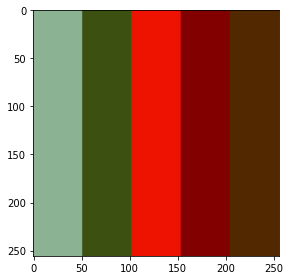

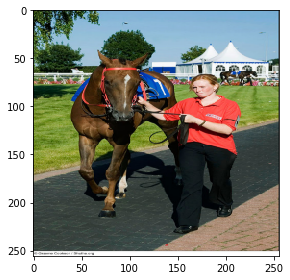

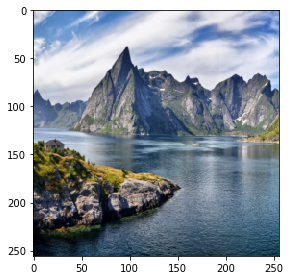

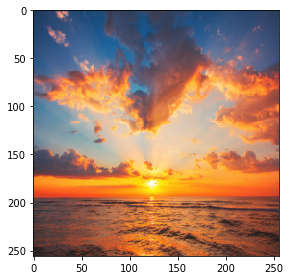

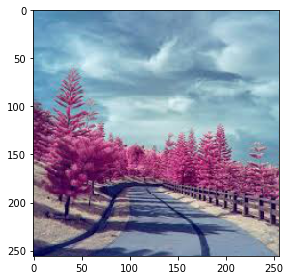

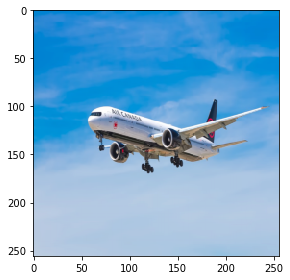

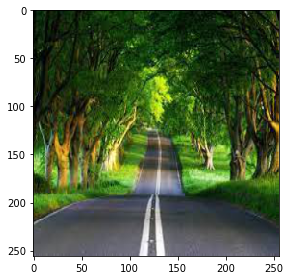

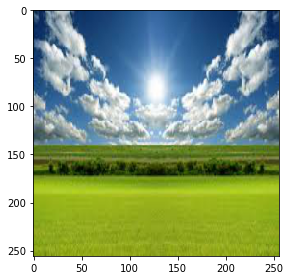

In [34]:
for img in imgNp:
    imshow(img)
    plt.show()

In [35]:
# creating the tf dataset

In [36]:
ds = tf.data.Dataset.from_tensor_slices(imgNp)

In [48]:
inceptionNet = InceptionResNetV2()

225222656/225209952 [==============================] - 2s 0us/step


In [123]:
def generate_features(image):
    lab = skimage.color.rgb2lab(image)
    _l = lab[:,:,0]
    gray_img = skimage.color.gray2rgb(_l)
    gray_img = resize(gray_img, output_shape=(299,299))
    gray_img = gray_img.reshape((1,) + gray_img.shape)
    features = inceptionNet.predict(gray_img)
    return tf.reshape(lab[:,:,0], shape=[256,256,1]), tf.reshape(features[0], shape=[1000,])

In [124]:
def generate_target(image):
    lab = skimage.color.rgb2lab(image)
    return tf.reshape(lab[:,:,1:] / 128, shape=[256,256,2])

In [125]:
def fixup_featureShape(_l, _feature):
    _l = _l.set_shape([256,256,1])
    _feature = _feature.set_shape([1000,])
    return _l, _feature

In [126]:
def fixup_targetShape(_ab):
    return _ab.set_shape([256,256,2])

In [127]:
# mapping the dataset

In [128]:
_X = ds.map(lambda x : tf.py_function(generate_features, [x], [tf.float32, tf.float32]))

In [129]:
_Y = ds.map(lambda x : tf.py_function(generate_target, [x], [tf.float32]))

In [130]:
_X

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [131]:
for x in _X.take(1):
    print(x)

InvalidArgumentError: ignored

In [132]:
_Y

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),)>

In [133]:
X = _X.map(lambda x, y: fixup_featureShape(x, y))

InvalidArgumentError: ignored

In [134]:
X

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>